# Simple case (sc) compartment model demonstration

In [1]:
from cmodels.sc_cmodel import sc_cmodel
from cmodels.sc_cmodel_sol import sc_cmodel_sol

from mmodels.monod_bb.sc_monod_bb import sc_monod_bb
from mmodels.monod_bb.im_monod_bb import im_monod_bb

from sd_design.ifr_sd.monod_bb_cstarv.ifr_sd_monod_bb_cstarv import ifr_sd_monod_bb_cstarv
from sd_design.ifr_sd.monod_bb_cstarv.ifr_sd_monod_bb_cstarv_sc_panel import ifr_sd_monod_bb_cstarv_sc_panel

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint

## Define the compartment model's process settings

In [3]:
STR_BS_cmod = sc_cmodel(excel_path='cmodels/cmodel_files/STR_4_cm/compmap_4cm.xlsx', N_rpm=140, Fg=0.79, p_head=1)

## Define parameters for the metabolic model

In [4]:
mmodel = sc_monod_bb(
    strain_id='DDB7',
    strain_description= 'WT E. coli'
    )

qS_max = 0.8
Ysx = 0.5
Ks = 0.05
Yso = 14 # copied from the WT strain
Ko = 0

mmodel.define_strain_params(qS_max,Ysx,Ks,Yso,Ko)

## Solve compartment model

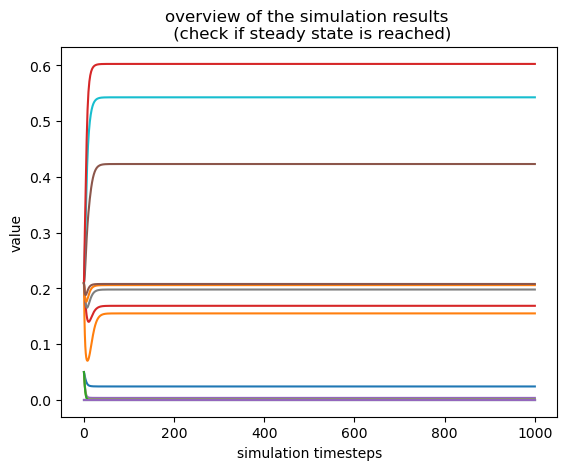

In [5]:
# initial values for one compartment
y0_1d = [
    0.05, #S 
    0.2095, #O
    0, #A
    0.2095 #yO
    ]

# multiply initial values with the number of compartments
y0 = y0_1d*STR_BS_cmod.n_comps
# simulation time
t_eval=np.linspace(0,1,1001)
# Biomass concentration 
X = 40 # to keep things consistent: A biomass concentration of 40 g/L was chosen for Ys = 0.5; hence Ysx = 0.52 should result in 41.6. This is to keep the glucose feed rate constant accross different examples. 
# Growth rate for the fed-batch
mu_set = 0.05
# Liquid volume in the whole reactor
VL = STR_BS_cmod.calc_sc_cmodel()[1].sum()
# Biomass yield
Ysx = mmodel.Ysx
# Glucose feed rate
Fs_feed = mu_set/Ysx*X*VL*1000
# compartment model instance
cmodel = STR_BS_cmod

# create a solution object
sol = sc_cmodel_sol(y0, t_eval, mmodel, cmodel, X, Fs_feed)

### Dispay dolution DataFrame

In [6]:
sol.sol_df

,S,O,A,yO,qS,mu,O_star,OTR,qO,comp_id,liquid_vol [L]
0,0.024139,0.155199,0.0,0.168818,0.257161,0.128581,0.378660,109.824580,3.291667,1,26.088830
1,0.003612,0.423142,0.0,0.198004,0.053650,0.026825,0.491441,45.281901,0.686725,2,17.174013
2,0.000531,0.542770,0.0,0.205925,0.008369,0.004185,0.560313,11.636563,0.107124,3,17.310869
3,0.000090,0.602676,0.0,0.207977,0.001440,0.000720,0.615597,8.577180,0.018431,4,17.430375


### Display solution in bioreactor

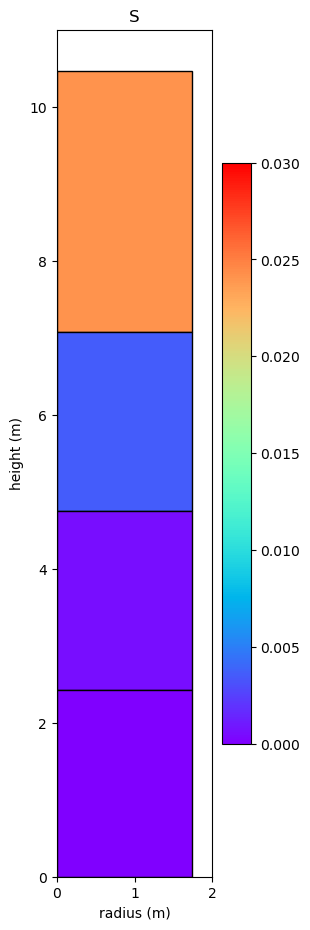

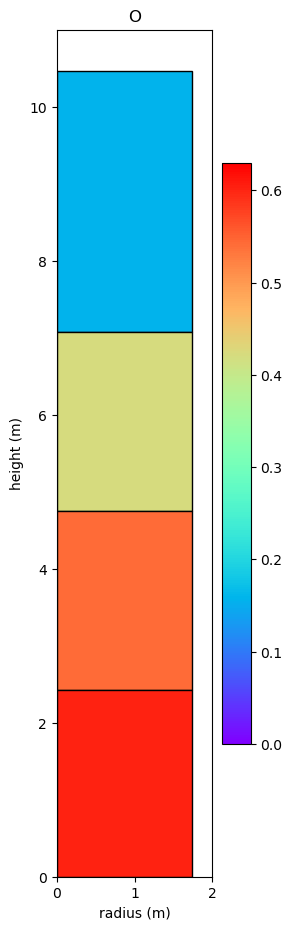

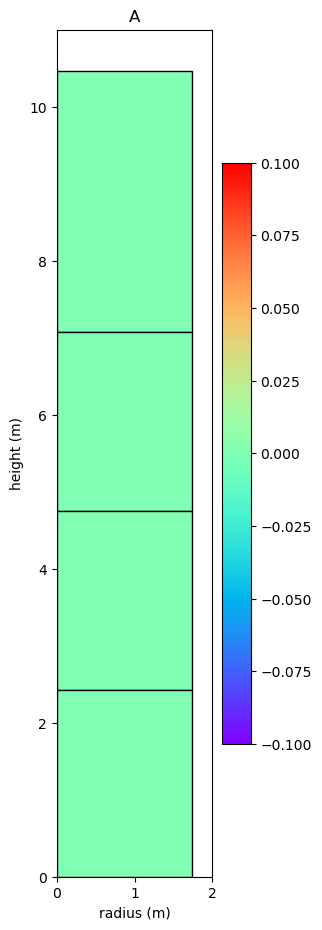

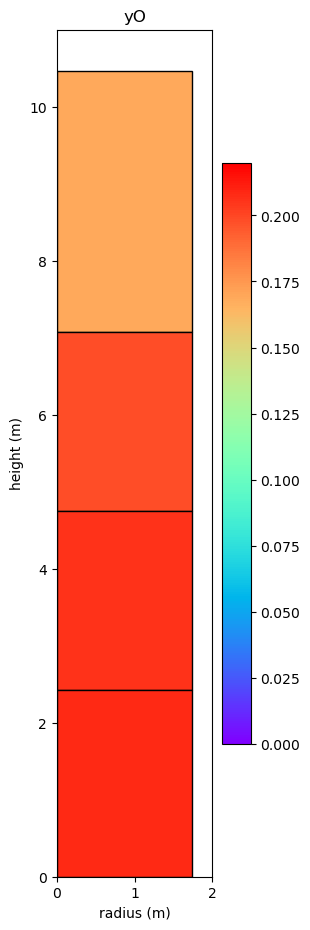

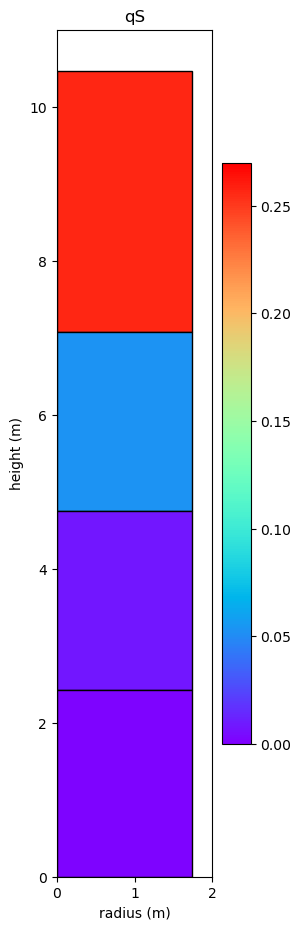

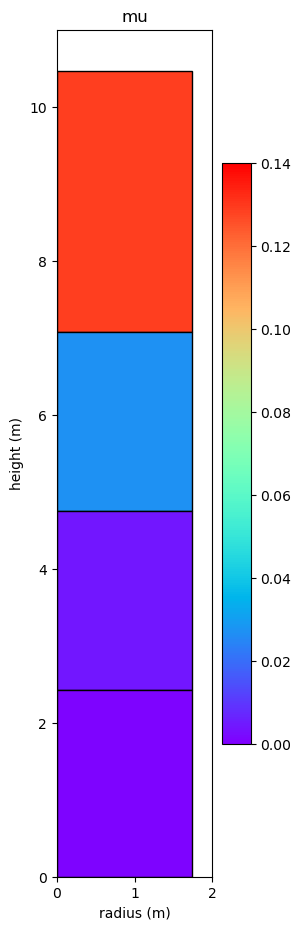

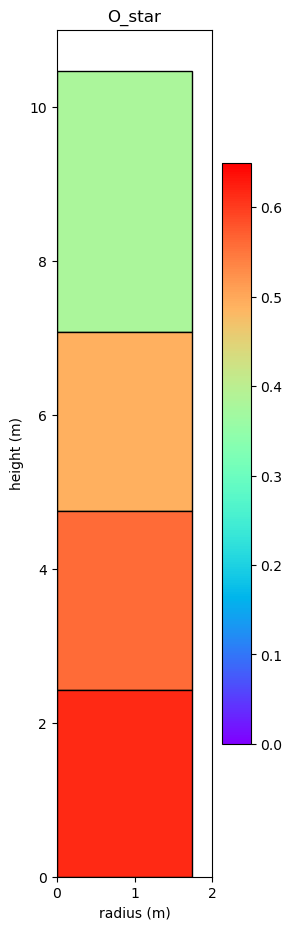

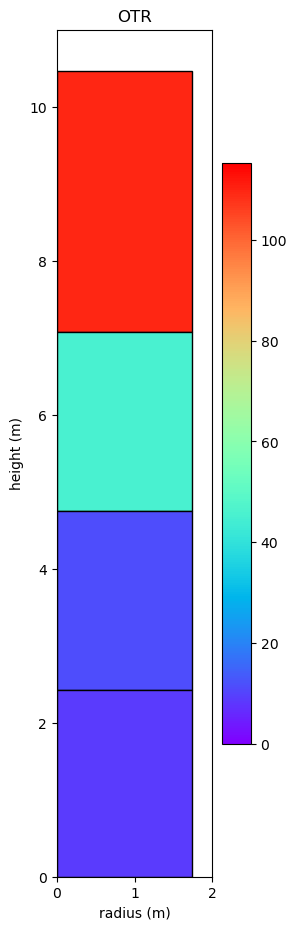

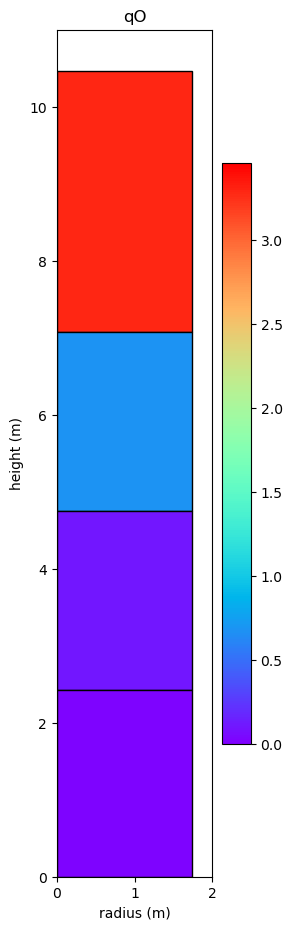

In [7]:
sol.plot_solution()

# Ideally mixed bioreactor metabolic model demo

In [8]:
im_mmodel = im_monod_bb(
    strain_id='DDB7',
    strain_description= 'WT E. coli'
    )

qS_max = 0.8
Ysx = 0.5
Ks = 0.05
Yso = 12.8 # copied from the WT strain
Ko = 0.002

im_mmodel.define_strain_params(qS_max,Ysx,Ks,Yso,Ko)

## Batch Mode

In [9]:
# ODE functions
func = im_mmodel.im_bmodel_odes
# initial values
y0 = [
    0.1,    # X [g/L]
    10,     # S [g/L]
    0.2095, # O [mol/L]
    0      # A [g/L]
]
# timesteps to evaluate
t_eval = np.linspace(0,20,1001)

# process parameter function arguments
kla = 1000 # kla [1/h]
pabs = 1 # pabs [bar]
yO = 0.2095 # yO [-]
Sf = 0 # Sf [g/L]
mu_set = 0 # mu_set [1/h]
V_fixed = True
X_fixed = False

# im_bmodel_odes(self,t,y,kla,pabs,yO,Sf:float,mu_set:float,V_fixed:bool=False,X_fixed:bool=False,pulse_cycle_time:float=None,pulse_on_ratio:float=None,returns:str='dydt'):
args_batch=(kla,pabs,yO,Sf,mu_set,V_fixed,X_fixed)

sol_batch = odeint(func=func,y0=y0,tfirst=True,t=t_eval,args=args_batch)

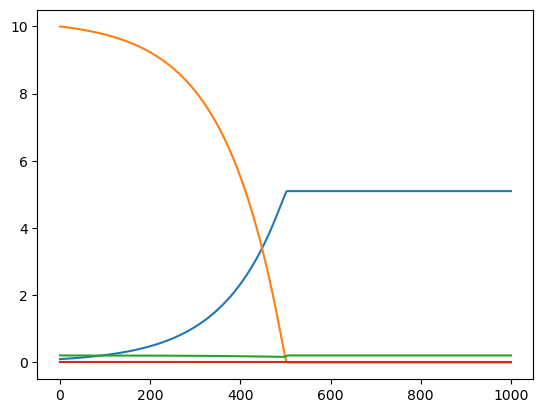

In [10]:
plt.plot(sol_batch);

## Chemostat Mode

In [11]:
# ODE functions
func = im_mmodel.im_bmodel_odes
# initial values
y0 = [
    10,    # X [g/L]
    0.05,     # S [g/L]
    0.2095, # O [mol/L]
    0      # A [g/L]
]
# timesteps to evaluate
t_eval = np.linspace(0,100,10001)

# process parameter function arguments
kla = 1000 # kla [1/h]
pabs = 1 # pabs [bar]
yO = 0.2095 # yO [-]
Sf = 20 # Sf [g/L]
mu_set = 0.05 # mu_set [1/h]
V_fixed = True
X_fixed = False

# im_bmodel_odes(self,t,y,kla,pabs,yO,Sf:float,mu_set:float,V_fixed:bool=False,X_fixed:bool=False,pulse_cycle_time:float=None,pulse_on_ratio:float=None,returns:str='dydt'):
args_chemostat=(kla,pabs,yO,Sf,mu_set,V_fixed,X_fixed)

sol_chemostat = odeint(func=func,y0=y0,tfirst=True,t=t_eval,args=args_chemostat)

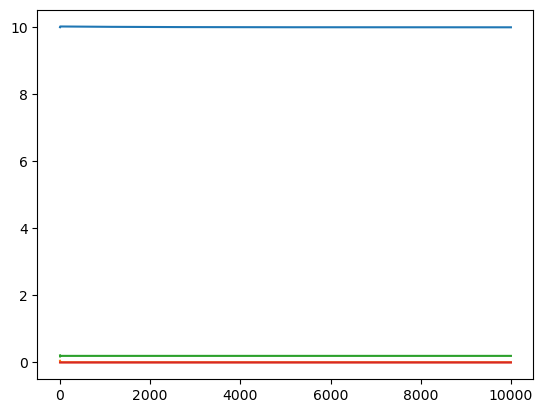

In [12]:
plt.plot(sol_chemostat);

## Fed-batch Mode

In [13]:
# ODE functions
func = im_mmodel.im_bmodel_odes
# initial values
y0 = [
    10,    # X [g/L]
    0.05,     # S [g/L]
    0.2095, # O [mol/L]
    0      # A [g/L]
]
# timesteps to evaluate
t_eval = np.linspace(0,100,10001)

# process parameter function arguments
kla = 1000 # kla [1/h]
pabs = 1 # pabs [bar]
yO = 0.2095 # yO [-]
Sf = 200 # Sf [g/L]
mu_set = 0.05 # mu_set [1/h]
V_fixed = False
X_fixed = False

# im_bmodel_odes(self,t,y,kla,pabs,yO,Sf:float,mu_set:float,V_fixed:bool=False,X_fixed:bool=False,pulse_cycle_time:float=None,pulse_on_ratio:float=None,returns:str='dydt'):
args_fedbatch=(kla,pabs,yO,Sf,mu_set,V_fixed,X_fixed)

sol_fedbatch = odeint(func=func,y0=y0,tfirst=True,t=t_eval,args=args_fedbatch)

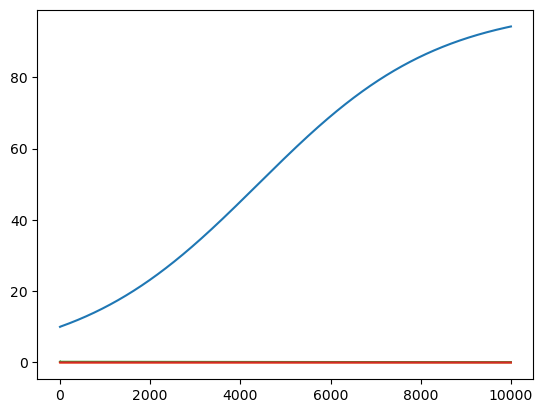

In [14]:
plt.plot(sol_fedbatch);

## Pulse simulation 

In [27]:
# ODE functions
func = im_mmodel.im_bmodel_odes
# initial values

X = 40

y0 = [
    X,    # X [g/L]
    0,     # S [g/L]
    0.2095, # O [mol/L]
    0      # A [g/L]
]
# timesteps to evaluate
t_eval = np.linspace(0,150/3600,10001)

# process parameter function arguments
kla = 1000 # kla [1/h]
pabs = 1 # pabs [bar]
yO = 0.2095 # yO [-]
Sf = 500 # Sf [g/L]
mu_set = 0.05 # mu_set [1/h]
V_fixed = True
X_fixed = True
pulse_cycle_time = 150 # [s]
pulse_on_ratio = 0.3 # [-]
D_set = mu_set/im_mmodel.Ysx*X/Sf


# im_bmodel_odes(self,t,y,kla,pabs,yO,Sf:float,mu_set:float,V_fixed:bool=False,X_fixed:bool=False,pulse_cycle_time:float=None,pulse_on_ratio:float=None,returns:str='dydt'):
args_pulse=(kla,pabs,yO,Sf,mu_set,V_fixed,X_fixed,D_set,pulse_cycle_time,pulse_on_ratio,'dydt')

sol_pulse = odeint(func=func,y0=y0,tfirst=True,t=t_eval,args=args_pulse)

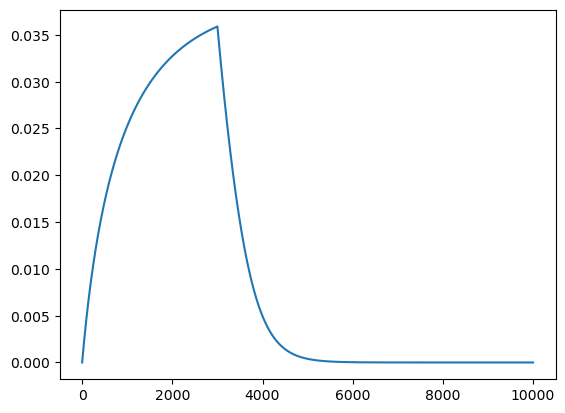

In [28]:
plt.plot(sol_pulse[:,1]);